# Boosting algorithm

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from math import log, exp

### Load data

In [3]:
# load and prepare data
data = np.loadtxt('sonar.all-data', delimiter=',', dtype=np.str_)
X = data[:, :-1].astype(np.float_)
y = (data[:, -1] == "M").astype(np.int_)
# Labels should be -1 and 1!
y = np.where(y == 0, -1, 1)

print(f"Number of samples:  {X.shape[0]}")
print(f"Number of features: {X.shape[-1]}")

Number of samples:  208
Number of features: 60


In [4]:
def KFold_split(X, y, k=5, test_ratio=0.2, seed=264):
    """
    Split dataset into a test dataset and train/val kfolds
    """
    # Extract test set from entire dataset
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=True, random_state=seed)
    
    # Create train/validation kfolds splitter
    KFold_splitter = KFold(n_splits=k, shuffle=True, random_state=seed)
    X_train_folds = []
    X_val_folds = []
    y_train_folds = []
    y_val_folds = []
    
    # Split train_val dataset into folds
    for (kth_fold_train_idxs, kth_fold_val_idxs) in KFold_splitter.split(X_train_val, y_train_val):
        X_train_folds.append(X_train_val[kth_fold_train_idxs])
        X_val_folds.append(X_train_val[kth_fold_val_idxs])
        y_train_folds.append(y_train_val[kth_fold_train_idxs])
        y_val_folds.append(y_train_val[kth_fold_val_idxs])
        
    print(f"Training dataset size: {len(X_train_folds[0])}")
    print(f"Validation dataset size: {len(X_val_folds[0])}")
    print(f"Test dataset size: {len(X_test)}")
    return X_train_folds, y_train_folds, X_val_folds, y_val_folds, X_test, y_test

X_train_folds, y_train_folds, X_val_folds, y_val_folds, X_test, y_test = KFold_split(X, y)

Training dataset size: 132
Validation dataset size: 34
Test dataset size: 42


### Boosting train and predict functions


**Note 1**: 

in scikit-learn, all supervised estimators implement a ``fit(X, y)`` method and a ``predict(X)`` method with ``X`` being unlabeled observations and  ``y`` being labels. 

Therefore ``Classifier`` parameter can be any sklearn class implementing a supervised classifier.

(See *The problem solved in supervised learning* section in the supervised learning tutorial from [sklearn documentation](https://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html)

**Note 2**: 

Some sklearn classifiers (such as [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), etc.)  have a ``sample_weight`` parameters in their ``fit`` and ``score`` methods, making it easy to implement a user-defined boosting algorithm. 

In [5]:
def boosting_train(
    X_train, 
    y_train, 
    n_clfs,           # number of classifier
    Classifier,       # Python class of classifier
    clfs_args = {},   # Specific python class of classifier's arguments
):
    """
    AdaBoost training algorithm
    """
    clfs = []
    alphas = []

    n = len(X_train) 
    # Initialize weights to 1/n
    sample_weight = np.ones((n,))/n
    for t in range(n_clfs):
        # -------------------------
        # Train a new classifier
        # -------------------------

        # Train a weak learner using the training data and the sample weights
        clf = Classifier(**clfs_args)
        clf.fit(X_train, y_train, sample_weight=sample_weight)
        clfs.append(clf)
        # Compute weighted training accuracy
        weighted_acc = clf.score(X_train, y_train, sample_weight=sample_weight)
        # Compute weighted training error 
        weighted_err = 1 - weighted_acc
        # Compute alpha_t (and avoid math errors)
        if weighted_err == 0:
            weighted_err = exp(-10)
        elif weighted_err == 1:
            weighted_err = 1-exp(-10)
        alpha = 1/2 * log((1-weighted_err)/weighted_err)
        alphas.append(alpha)

        # -------------------------
        # Update weights
        # -------------------------
        y_pred = clf.predict(X_train)
        # Weights increase only if y_train != y_pred 
        # so that we concentrate on “hardest” examples
        sample_weight = sample_weight * np.exp(-alpha * y_train * y_pred)
        # Normalize weights
        sample_weight /= np.linalg.norm(sample_weight)
    # Return the list of trained classifiers composing the boosting classifier
    # with their corresponding weights 'alphas'
    return(clfs, alphas)

def boosting_predict(
    clfs,       # list of classifiers composing the boosting classifier
    alphas,     # Weights associated with each classifier in 'clfs'
    X,
):
    """
    Adaboost predict algorithm
    """
    y_pred= []
    for row in X:
        # Get a prediction of 'row' for each classifier trained
        predictions = [clf.predict([row])[0] for clf in clfs]
        # Get the adaboost prediction by taking the (weighted) majority vote
        adaboost_pred = np.sign(np.sum(np.array(alphas)*np.array(predictions)))
        y_pred.append(adaboost_pred)
    return(np.array(y_pred))

### Boosting pipeline using cross validation

In [6]:
def boosting_CV_pipeline(
    n_clfs,                              # number of classifiers
    Classifier = DecisionTreeClassifier, # Python class of classifier
    clfs_args = {"max_depth" : 1},       # Classifier's hparams
):
    """
    Cross validation step of the machine learning pipeline for a boosting algorithm
    """
    train_accs = []
    val_accs = []
    
    # For each set of k-folds get the bagging classifier and its accuracy
    for X_train_fold, X_val_fold, y_train_fold, y_val_fold in zip(
        X_train_folds, X_val_folds, y_train_folds, y_val_folds
        ):
        
        # 'clfs' are the classifiers associated with the current boosting classifier
        clfs, alphas = boosting_train(
            X_train_fold, 
            y_train_fold, 
            n_clfs, 
            Classifier = Classifier, 
            clfs_args = clfs_args,
        )
        
        # Training scores of the current bagging classifier
        y_pred = boosting_predict(clfs, alphas, X_train_fold)
        train_accs.append(accuracy_score(y_train_fold, y_pred))
        
        # Validation scores of the current bagging classifier
        y_pred = boosting_predict(clfs, alphas, X_val_fold)
        val_accs.append(accuracy_score(y_val_fold, y_pred))
        
    # Return the mean scores 
    return np.mean(train_accs), np.mean(val_accs)

### Training different boosting models on the sonar dataset

In [7]:
Classifier = DecisionTreeClassifier
clfs_args={"max_depth" : 1}

mean_train_accs = []
mean_val_accs = []
list_n_clfs = [1, 10, 50, 100, 200, 300, 400]

# For each hyper-parameter instance, do KFold cross validation:
for n_clfs in list_n_clfs:
    mean_train_acc, mean_val_acc =  boosting_CV_pipeline(
        n_clfs = n_clfs,
        Classifier = Classifier,
        clfs_args = clfs_args
    )
    print(f"\nNumber of trees: {n_clfs}")
    print(f"Mean training accuracy: {mean_train_acc:.4f}")
    print(f"Mean validation accuracy: {mean_val_acc:.4f}")

    mean_train_accs.append(mean_train_acc)
    mean_val_accs.append(mean_val_acc)


Number of trees: 1
Mean training accuracy: 0.7635
Mean validation accuracy: 0.6868

Number of trees: 10
Mean training accuracy: 0.9382
Mean validation accuracy: 0.7349

Number of trees: 50
Mean training accuracy: 1.0000
Mean validation accuracy: 0.8435

Number of trees: 100
Mean training accuracy: 1.0000
Mean validation accuracy: 0.8556

Number of trees: 200
Mean training accuracy: 1.0000
Mean validation accuracy: 0.8556

Number of trees: 300
Mean training accuracy: 1.0000
Mean validation accuracy: 0.8615

Number of trees: 400
Mean training accuracy: 1.0000
Mean validation accuracy: 0.8615


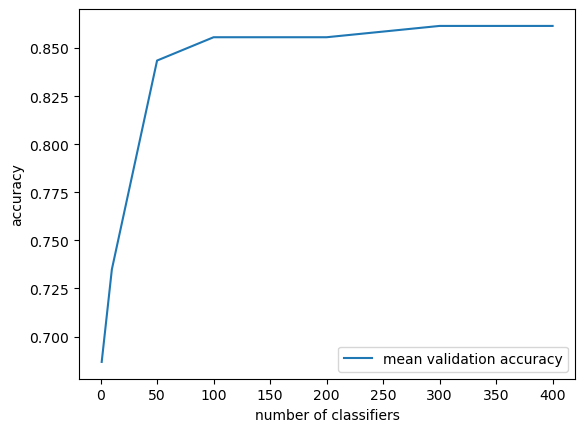

In [8]:
plt.plot(list_n_clfs, mean_val_accs, label="mean validation accuracy")
plt.xlabel("number of classifiers")
plt.ylabel("accuracy")
plt.legend()
plt.show()

### Selecting and evaluating the best boosting model

In [9]:
# Select best model
i_best = np.argmax(mean_val_accs)

# Evaluate best model
X_train_val = np.concatenate([X_train_folds[0], X_val_folds[0]])
y_train_val = np.concatenate([y_train_folds[0], y_val_folds[0]])
best_model, best_alphas = boosting_train(
    X_train_val, y_train_val, list_n_clfs[i_best], Classifier, clfs_args
)

print(f"\nBest model selected with n_trees= {list_n_clfs[i_best]}")
y_pred = boosting_predict(best_model, best_alphas, X_train_val)
acc = accuracy_score(y_train_val, y_pred)
print(f"\nTraining accuracy (incl. validation dataset): {acc:.4f}")
y_pred = boosting_predict(best_model, best_alphas, X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.4f}")


Best model selected with n_trees= 300

Training accuracy (incl. validation dataset): 1.0000
Test accuracy: 0.8095
